In [77]:
#Importando Bibliotecas
import pandas as pd
import statistics as sts
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importando os dados
dados1 = pd.read_csv("Dados_vale_credito_tabela1.csv", sep = ",")
dados2 = pd.read_csv("Dados_vale_credito_tabela2.csv", sep = ",")

**1. ALGUMAS ESTATÍSTICAS DA COMPRA**

In [4]:
#Tipos de clientes
dados1.groupby(['DESCRICAO_NIVEL']).size()

DESCRICAO_NIVEL
AZUL          11
DIAMANTE     297
DIAMANTE+    448
OURO         166
PRATA         78
dtype: int64

In [5]:
#Porcentagens de níveis de clientes
total1 = dados1.shape[0]
azul = dados1[dados1['DESCRICAO_NIVEL'] == 'AZUL']
dima = dados1[dados1['DESCRICAO_NIVEL'] == 'DIAMANTE']
dimap = dados1[dados1['DESCRICAO_NIVEL'] == 'DIAMANTE+']
ouro = dados1[dados1['DESCRICAO_NIVEL'] == 'OURO']
prata = dados1[dados1['DESCRICAO_NIVEL'] == 'PRATA']

print("Azul =", 100*azul.shape[0]/total1)
print("Diamante =", 100*dima.shape[0]/total1)
print("Diamante+ =", 100*dimap.shape[0]/total1)
print("Ouro =", 100*ouro.shape[0]/total1)
print("Prata =", 100*prata.shape[0]/total1)



Azul = 1.1
Diamante = 29.7
Diamante+ = 44.8
Ouro = 16.6
Prata = 7.8


Mais de 70% dos clientes desses dados estão acima da categoria Ouro.

In [3]:
dados2.groupby(['TIPO_TRANSACAO_VC']).size()

TIPO_TRANSACAO_VC
AJUSTE_CONTABIL_OU_LANCAM_INCORRETO               369
AJUSTE_LANCAMENTO_INCORRETO                        15
CREDITO_CONVERSAO_CRED_GERADO_DEVOLUCAO            52
CREDITO_GERADO_DEVOLUCAO_COMPRAS                  156
CREDITO_GERADO_POR_COMPRA_DE_VC                 24056
CREDITO_POR_COMPRA_LISTA_PRESENTES               6803
CREDITO_POR_TROCO                              234875
CREDITO_PREMIACAO_FUNCIONARIO                     697
CREDITO_PREMIACAO_GERENCIAL_CLIENTES              615
DEBITO_AUTOMATICO_PAG_PRESTACOES                22119
DEBITO_COMPRA_COM_VC                            32591
DEBITO_DEVOLUCAO_COMPRA_DE_VC                      25
DEBITO_DEVOLUCAO_COMPRA_FEITA_COM_VC             1004
DEBITO_DUPLICIDADE_LANCAMENTO                       1
DEBITO_ESTORNO_LISTA_PRESENTES                     16
DEBITO_ESTORNO_TROCO                                1
DEBITO_PAGAMENTO_COM_VC                         56800
DEBITO_POR_ESTORNO_TROCO                           16
DOACAO    

Analisando esses dados que foram apresentados é possível ver que os registros que simbolizam a compra de um Vale Crédito são aqueles em que o aatributo TIPO_TRANSACAO_VC é igual a CREDITO_GERADO_POR_COMPRA_DE_VC. Sendo assim, temos 24056 compras de Vale Créditos no periodo em que foram coletados os dados.

In [3]:
#Média de Vale Créditos vendidos por loja no período de teempo em que foram coletados os dados
k = round(sts.mean(dados2[dados2["TIPO_TRANSACAO_VC"] == 'CREDITO_GERADO_POR_COMPRA_DE_VC'].groupby(['LOJA']).size()))
k

512

Assim, cada loja vendeu em média 512 Vale Créditos no período da coleta dos dados.

In [8]:
#Valor médio adicionado por vale compras
lista = dados2[dados2['TIPO_TRANSACAO_VC'] == 'CREDITO_GERADO_POR_COMPRA_DE_VC']
media_valores = round(sts.mean(lista['VALOR_MOVIMENTADO']), 2)
media_valores

188.31

Assim, cada clientre adicionou um crédito de em média R$188,31 à sua conta por vale crédito comprado.

In [7]:
#Porcentagem de compras com débito e crédito
total2 = dados2.shape[0]
a = dados2[dados2['DEBITO_OU_CREDITO'] == 'CREDITO']
b = dados2[dados2['DEBITO_OU_CREDITO'] == 'DEBITO']

print("Crédito =", round(100*a.shape[0]/total2, 2))
print("Débito =", round(100*b.shape[0]/total2, 2))

Crédito = 70.65
Débito = 29.35


**2. COMO OS DADOS ESTÃO DISTRIBUÍDOS NO TEMPO?**

In [10]:
#Convertendo as datas 
dateparse = lambda dates : datetime.strptime(dates, '%Y-%m-%d')
dados_ts = pd.read_csv("Dados_vale_credito_tabela2.csv", parse_dates=['DATA_DA_MOVIMENTACAO'],
                      date_parser = dateparse)

In [11]:
#Organizando os dados em ordem crescente de data
dados_ts.sort_values(by = "DATA_DA_MOVIMENTACAO", ascending = True, inplace = True)
dados_ts

,CLIENTE,DEBITO_OU_CREDITO,TIPO_TRANSACAO_VC,ID_LISTA_PRESENTES,PEDIDO_BOL,VALOR_MOVIMENTADO,SALDO,MOEDA,DATA_DA_MOVIMENTACAO,FATURA,DATA_CRIACAO,LOJA
202188,1955961,CREDITO,CREDITO_POR_TROCO,0,0,0.08,1.12,BRL,2016-01-02,NaN,2016-01-02,109.0
349534,1871651,CREDITO,CREDITO_POR_TROCO,0,0,0.24,1.53,BRL,2016-01-02,NaN,2016-01-02,106.0
298604,1396511,CREDITO,CREDITO_POR_TROCO,0,0,0.66,0.66,BRL,2016-01-02,NaN,2016-01-02,101.0
366757,250708,CREDITO,CREDITO_POR_TROCO,0,0,1.09,1.09,BRL,2016-01-02,NaN,2016-01-02,114.0
3569,2275559,CREDITO,CREDITO_POR_COMPRA_LISTA_PRESENTES,389536,0,108.00,108.00,BRL,2016-01-02,135848357.0,2016-01-02,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...
93013,1454035,DEBITO,DEBITO_AUTOMATICO_PAG_PRESTACOES,0,0,-0.83,0.00,BRL,2020-10-18,NaN,2020-10-18,100.0
141830,1243523,CREDITO,CREDITO_GERADO_POR_COMPRA_DE_VC,0,0,33.88,36.27,BRL,2020-10-18,165967001.0,2020-10-18,115.0
290525,1887628,DEBITO,DEBITO_AUTOMATICO_PAG_PRESTACOES,0,0,-156.47,119.91,BRL,2020-10-18,NaN,2020-10-18,100.0
346624,1430191,DEBITO,DEBITO_AUTOMATICO_PAG_PRESTACOES,0,0,-0.65,0.00,BRL,2020-10-18,NaN,2020-10-18,100.0


Observando a coluna DATA_DA_MOVIMENTACAO vemos que o período de tempo dessa coleta de dados é de janeiro de 2016 até outubro de 2020

In [13]:
#Alterando o índice para as datas
#Importante para o caso de se querer trabalhar com séries temporais nesses dados
dados_ts.index = dados_ts.DATA_DA_MOVIMENTACAO

In [79]:
#Criar um conjunto onde a operação registrada é a de realização de compra de Vale Crédito
k = dados_ts[dados_ts['TIPO_TRANSACAO_VC'] == "CREDITO_GERADO_POR_COMPRA_DE_VC"]
k.index.name = None

#Cada dia tem a compra uma certa quantidade de Vale Créditos, então criei uma série temporal com cada uma dessas quantidades
ts = k.groupby(['DATA_DA_MOVIMENTACAO']).size()
ts




DATA_DA_MOVIMENTACAO
2019-01-04     2
2019-01-06     3
2019-01-07     1
2019-01-08     1
2019-01-09     3
              ..
2020-10-14    46
2020-10-15    70
2020-10-16    49
2020-10-17    55
2020-10-18    19
Length: 637, dtype: int64

Observando essa série temporal, temos que a venda de Vale Créditos só se iniciou em janeiro de 2019, seguindo até os dias atuais 

**3. COMO A COMPRA DOS VALE CRÉDITOS CRESCEU/DIMINUIU NOS ÚLTIMOS 6 MESES?**

<AxesSubplot:title={'center':'COMPRA DE VC NOS ÚLTIMOS 6 MESES'}, xlabel='DATA DA COMPRA', ylabel='QUANTIDADE'>

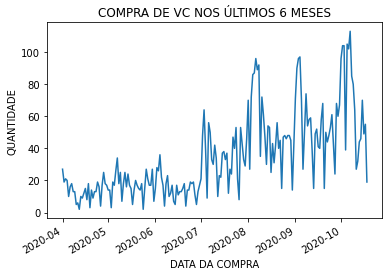

In [80]:
#Plotar o gráfico para se ter uma visão geral da série temporal de compra de VC nos últimos 6 meses
ts1 = ts['2020-04':]
qnt = ts1.shape[0]
ts1.plot(title = 'COMPRA DE VC NOS ÚLTIMOS 6 MESES', xlabel = 'DATA DA COMPRA', ylabel = 'QUANTIDADE')

In [81]:
#Decomposição da série com base na quantidade de observações nos últimos 6 meses
decomposicao = seasonal_decompose(ts1, period = int(qnt/2))

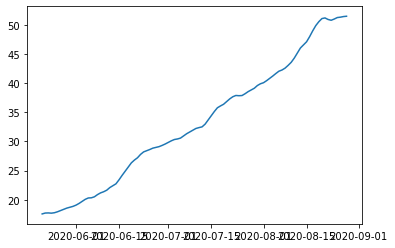

In [82]:
#Analisar a tendência nos últimos 6 meses
tendencia = decomposicao.trend
plt.plot(tendencia)

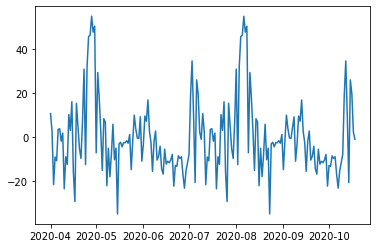

In [83]:
#Analisar a sazonalidade dos últimos 6 meses
sazonal = decomposicao.seasonal
plt.plot(sazonal)

Com esses gráficos podemos observar que a compra de VC nos últimos 6 meses seguiu uma tendência crescente com uma sazonalidade até que bem regular que ocorre num período de um pouco mais de 3 meses, com um pico de compras no final do primeiro mês e a maior baixa um pouco antes da metade do segundo.

**4. QUAL MODELO VOCÊ USARIA PARA PREVER O CRESCIMENTO NOS PRÓXIMOS 6 MESES?**

Usaria o modelo ARIMA para prever pontos futuros da séria baseado nos dados desde janeiro de 2019, porém não sei como implementá-lo.